In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data into a pandas DataFrame
data = pd.read_csv('GazeDataPilot\gaze_data_all_trials.csv', sep=',')

# Define screen resolution (you can adjust this based on Unity's settings)
screen_width = 3840
screen_height = 2160

In [2]:
! pip install numpy
! pip install scipy

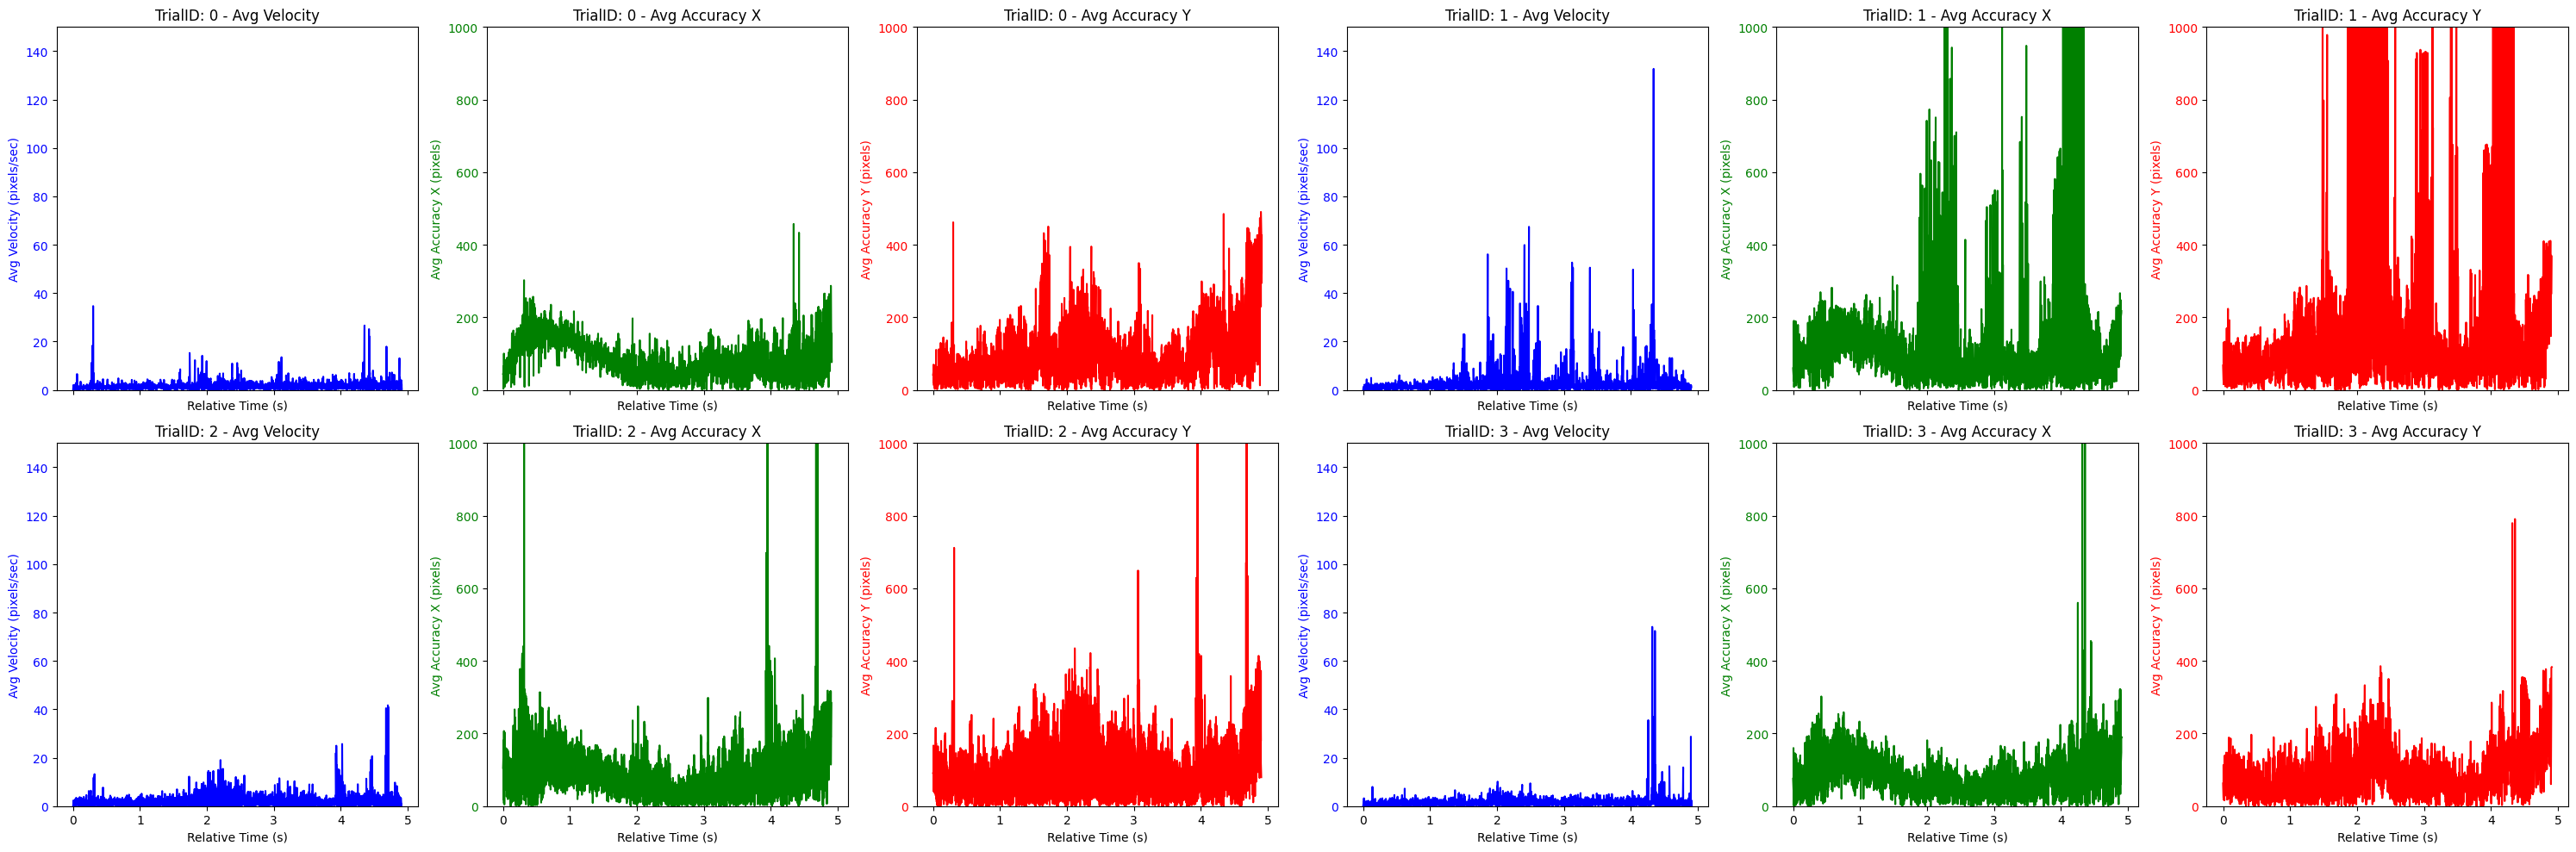

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Compute Eye Movement Velocity using Relative Time
def compute_velocity(df):
    # Calculate time difference instead of frame difference
    df['TimeDiff'] = df['RelativeTime'].diff().fillna(1e-5)  # Small value to avoid division by zero
    df['PosDiff'] = np.sqrt((df['BestPogX'].diff() ** 2) + (df['BestPogY'].diff() ** 2))
    df['Velocity'] = df['PosDiff'] / df['TimeDiff']  # Velocity as pixels per second
    return df

# Step 2: Compute Accuracy Relative to the Ball Position (separate X and Y)
def compute_accuracy(df, screen_width, screen_height):
    df['MappedPogX'] = df['BestPogX'] * screen_width
    df['MappedPogY'] = df['BestPogY'] * screen_height

    # Extract BallX and BallY from the ScreenBallPosition column
    df[['BallX', 'BallY']] = df['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
    df = df[(df['BallX'] >= 0) & (df['BallY'] >= 0)]
    df['AccuracyX'] = np.abs(df['MappedPogX'] - df['BallX'])
    df['AccuracyY'] = np.abs(df['MappedPogY'] - df['BallY'])
    return df

# Step 3: Align time values and average across trials of the same type (trialID)
def align_and_average_across_trials(df, screen_width, screen_height):
    # Align Time: Create RelativeTime for each trial, starting at 0
    df['RelativeTime'] = df.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())

    # Compute Velocity and Accuracy
    df = compute_velocity(df)
    df = compute_accuracy(df, screen_width, screen_height)
    
    # Find the maximum duration (relative time) for each trialID
    max_duration = df.groupby('TrialID')['RelativeTime'].max().max()

    # Step 4: Interpolate missing values for shorter trials
    all_relative_times = pd.DataFrame({'RelativeTime': np.arange(0, max_duration, 0.01)})  # Example resolution of 10ms
    avg_df = []
    
    for trial_id in df['TrialID'].unique():
        trial_data = df[df['TrialID'] == trial_id]
        
        # Align and interpolate each trial by trial ID
        avg_by_trial_id = trial_data.groupby('RelativeTime').agg(
            AvgVelocity=('Velocity', 'mean'),
            AvgAccuracyX=('AccuracyX', 'mean'),
            AvgAccuracyY=('AccuracyY', 'mean')
        ).reset_index()

        avg_by_trial_id['TrialID'] = trial_id
        avg_df.append(avg_by_trial_id)

    # Concatenate all averaged trials
    avg_df = pd.concat(avg_df)
    return avg_df

# Step 5: Plot the aligned and averaged metrics by selected trialIDs
def plot_aligned_average_metrics_by_trialID(avg_df, trial_ids, screen_width, screen_height):
    filtered_df = avg_df[avg_df['TrialID'].isin(trial_ids)]
    unique_trial_ids = sorted(filtered_df['TrialID'].unique())  # Ensure TrialIDs are ordered
    num_trials = len(unique_trial_ids)
    num_rows = (num_trials + 1) // 2  # Each row contains 2 trials

    # Create subplots: 6 columns (2 trials per row, each with velocity and X/Y accuracy)
    fig, axes = plt.subplots(num_rows, 6, figsize=(30, 5 * num_rows), sharex=True)

    for i, trial_id in enumerate(unique_trial_ids):
        trial_avg = filtered_df[filtered_df['TrialID'] == trial_id]

        row = i // 2
        col_velocity = (i % 2) * 3  # First column for velocity
        col_accuracy_x = col_velocity + 1  # Second column for X accuracy
        col_accuracy_y = col_velocity + 2  # Third column for Y accuracy

        # Plot average Velocity in the first column for each trialID
        ax_velocity = axes[row, col_velocity]
        ax_velocity.plot(trial_avg['RelativeTime'], trial_avg['AvgVelocity'], color='blue', label='Avg Velocity')
        ax_velocity.set_ylabel('Avg Velocity (pixels/sec)', color='blue')
        ax_velocity.tick_params(axis='y', labelcolor='blue')
        ax_velocity.set_title(f'TrialID: {trial_id} - Avg Velocity')
        ax_velocity.set_ylim([0, 150])
        ax_velocity.set_xlabel('Relative Time (s)')

        # Plot average Accuracy (X) in the second column for each trial
        ax_accuracy_x = axes[row, col_accuracy_x]
        ax_accuracy_x.plot(trial_avg['RelativeTime'], trial_avg['AvgAccuracyX'], color='green', label='Avg Accuracy X')
        ax_accuracy_x.set_ylabel('Avg Accuracy X (pixels)', color='green')
        ax_accuracy_x.tick_params(axis='y', labelcolor='green')
        ax_accuracy_x.set_title(f'TrialID: {trial_id} - Avg Accuracy X')
        ax_accuracy_x.set_ylim([0, 1000])
        ax_accuracy_x.set_xlabel('Relative Time (s)')

        # Plot average Accuracy (Y) in the third column for each trial
        ax_accuracy_y = axes[row, col_accuracy_y]
        ax_accuracy_y.plot(trial_avg['RelativeTime'], trial_avg['AvgAccuracyY'], color='red', label='Avg Accuracy Y')
        ax_accuracy_y.set_ylabel('Avg Accuracy Y (pixels)', color='red')
        ax_accuracy_y.tick_params(axis='y', labelcolor='red')
        ax_accuracy_y.set_title(f'TrialID: {trial_id} - Avg Accuracy Y')
        ax_accuracy_y.set_ylim([0, 1000])
        ax_accuracy_y.set_xlabel('Relative Time (s)')

    fig.tight_layout()
    plt.show()

# Step 6: Align, average, and plot metrics with selected trialIDs
selected_trial_ids = [0, 1, 2, 3]  # Example list of trial IDs to plot
aligned_avg_data_by_trial = align_and_average_across_trials(data, screen_width, screen_height)
plot_aligned_average_metrics_by_trialID(aligned_avg_data_by_trial, selected_trial_ids, screen_width, screen_height)


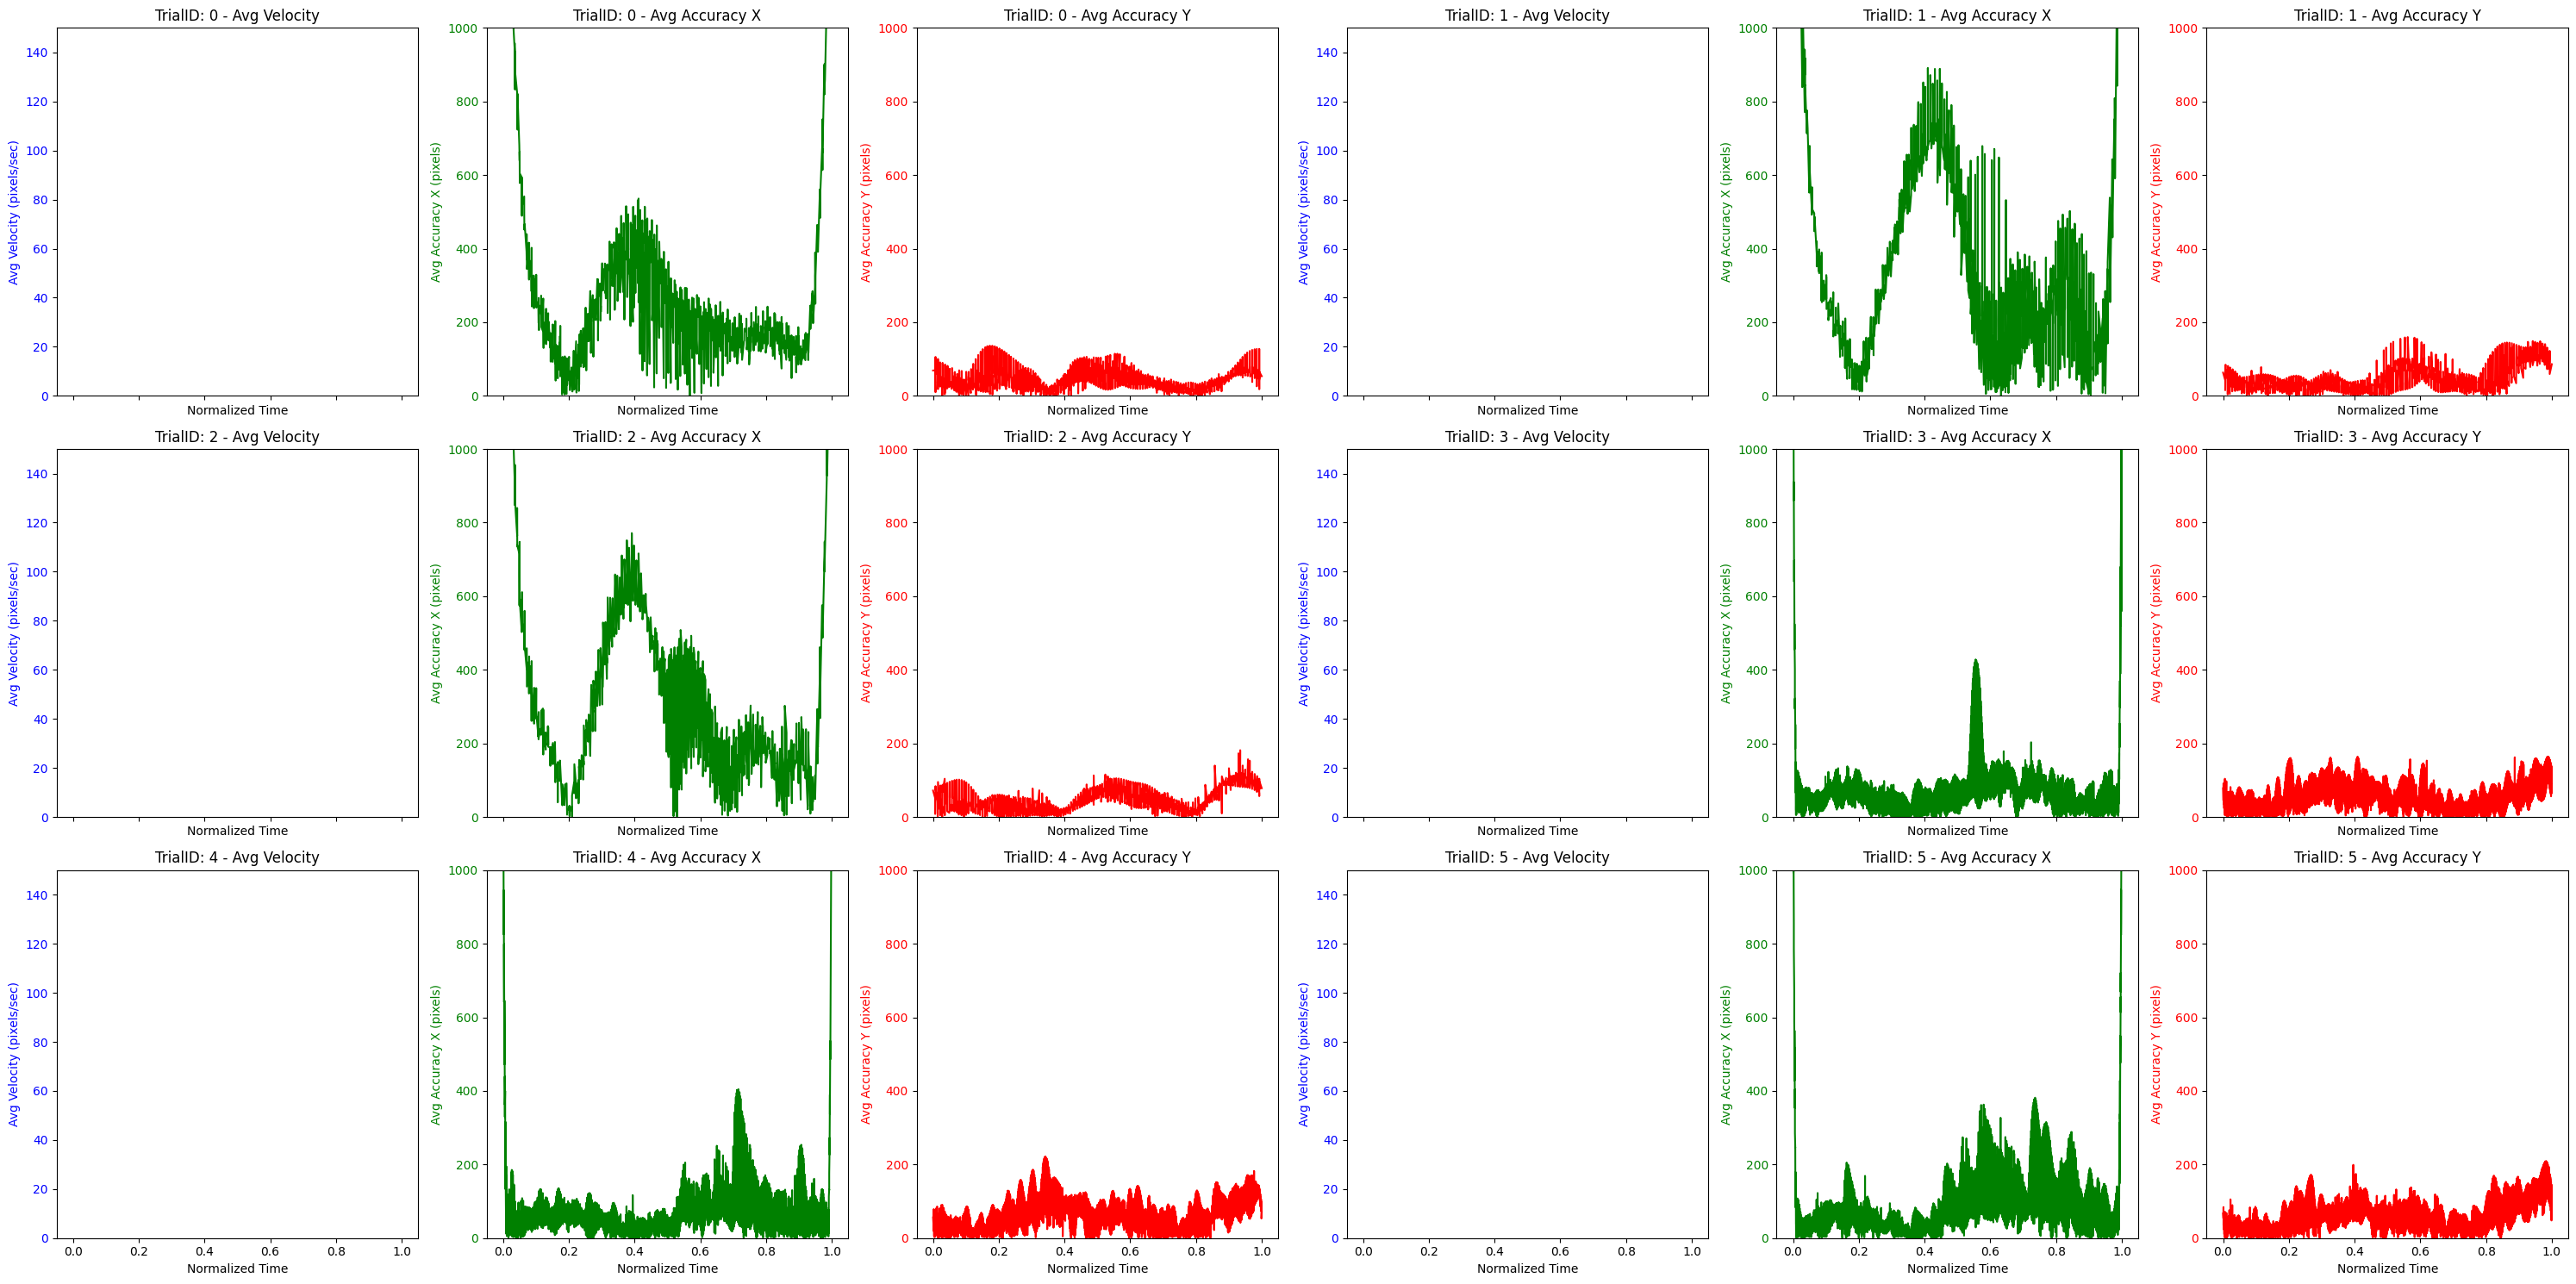

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Compute Eye Movement Velocity using Relative Time
def compute_velocity(df):
    # Calculate time difference instead of frame difference
    df['TimeDiff'] = df['RelativeTime'].diff().fillna(1e-5)  # Small value to avoid division by zero
    df['PosDiff'] = np.sqrt((df['BestPogX'].diff() ** 2) + (df['BestPogY'].diff() ** 2))
    df['Velocity'] = df['PosDiff'] / df['TimeDiff']  # Velocity as pixels per second
    return df

# Step 2: Compute Accuracy Relative to the Ball Position (separate X and Y)
def compute_accuracy(df, screen_width, screen_height):
    df['MappedPogX'] = df['BestPogX'] * screen_width
    df['MappedPogY'] = df['BestPogY'] * screen_height

    # Extract BallX and BallY from the ScreenBallPosition column
    df[['BallX', 'BallY']] = df['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
    df = df[(df['BallX'] >= 0) & (df['BallY'] >= 0)]
    df['AccuracyX'] = np.abs(df['MappedPogX'] - df['BallX'])
    df['AccuracyY'] = np.abs(df['MappedPogY'] - df['BallY'])
    return df

# Step 3: Align time values, normalize to [0, 1], and average across trials of the same type (trialID)
def align_and_average_across_trials(df, screen_width, screen_height, trial_ids=None):
    # Filter DataFrame to include only specified trial IDs
    if trial_ids is not None:
        df = df[df['TrialID'].isin(trial_ids)]
    
    # Align Time: Create RelativeTime for each trial, starting at 0
    df['RelativeTime'] = df.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())
    
    # Compute Velocity and Accuracy
    df = compute_velocity(df)
    df = compute_accuracy(df, screen_width, screen_height)
    
    # Normalize Relative Time to the range [0, 1]
    df['MaxRelativeTime'] = df.groupby('TrialNumber')['RelativeTime'].transform('max')
    df['NormalizedTime'] = df['RelativeTime'] / df['MaxRelativeTime']

    avg_df = []
    
    for trial_id in df['TrialID'].unique():
        trial_data = df[df['TrialID'] == trial_id]

        # Now average across all trials of the same type (trialID)
        avg_by_trial_id = trial_data.groupby('NormalizedTime').agg(
            AvgVelocity=('Velocity', 'mean'),
            AvgAccuracyX=('AccuracyX', 'mean'),
            AvgAccuracyY=('AccuracyY', 'mean')
        ).reset_index()

        avg_by_trial_id['TrialID'] = trial_id
        avg_df.append(avg_by_trial_id)

    # Concatenate all averaged trials
    avg_df = pd.concat(avg_df)
    return avg_df

# Step 4: Plot the aligned and averaged metrics by trialID
def plot_aligned_average_metrics_by_trialID(avg_df, screen_width, screen_height, trial_ids=None):
    # Filter avg_df to include only specified trial IDs
    if trial_ids is not None:
        avg_df = avg_df[avg_df['TrialID'].isin(trial_ids)]
    
    unique_trial_ids = sorted(avg_df['TrialID'].unique())  # Ensure TrialIDs are ordered
    num_trials = len(unique_trial_ids)
    num_rows = (num_trials + 1) // 2  # Each row contains 2 trials

    # Create subplots: 6 columns (2 trials per row, each with velocity and X/Y accuracy)
    fig, axes = plt.subplots(num_rows, 6, figsize=(30, 5 * num_rows), sharex=True)

    for i, trial_id in enumerate(unique_trial_ids):
        trial_avg = avg_df[avg_df['TrialID'] == trial_id]

        row = i // 2
        col_velocity = (i % 2) * 3  # First column for velocity
        col_accuracy_x = col_velocity + 1  # Second column for X accuracy
        col_accuracy_y = col_velocity + 2  # Third column for Y accuracy

        # Plot average Velocity in the first column for each trialID
        ax_velocity = axes[row, col_velocity]
        ax_velocity.plot(trial_avg['NormalizedTime'], trial_avg['AvgVelocity'], color='blue', label='Avg Velocity')
        ax_velocity.set_ylabel('Avg Velocity (pixels/sec)', color='blue')
        ax_velocity.tick_params(axis='y', labelcolor='blue')
        ax_velocity.set_title(f'TrialID: {trial_id} - Avg Velocity')
        ax_velocity.set_ylim([0, 150])
        ax_velocity.set_xlabel('Normalized Time')

        # Plot average Accuracy (X) in the second column for each trial
        ax_accuracy_x = axes[row, col_accuracy_x]
        ax_accuracy_x.plot(trial_avg['NormalizedTime'], trial_avg['AvgAccuracyX'], color='green', label='Avg Accuracy X')
        ax_accuracy_x.set_ylabel('Avg Accuracy X (pixels)', color='green')
        ax_accuracy_x.tick_params(axis='y', labelcolor='green')
        ax_accuracy_x.set_title(f'TrialID: {trial_id} - Avg Accuracy X')
        ax_accuracy_x.set_ylim([0, 1000])
        ax_accuracy_x.set_xlabel('Normalized Time')

        # Plot average Accuracy (Y) in the third column for each trial
        ax_accuracy_y = axes[row, col_accuracy_y]
        ax_accuracy_y.plot(trial_avg['NormalizedTime'], trial_avg['AvgAccuracyY'], color='red', label='Avg Accuracy Y')
        ax_accuracy_y.set_ylabel('Avg Accuracy Y (pixels)', color='red')
        ax_accuracy_y.tick_params(axis='y', labelcolor='red')
        ax_accuracy_y.set_title(f'TrialID: {trial_id} - Avg Accuracy Y')
        ax_accuracy_y.set_ylim([0, 1000])
        ax_accuracy_y.set_xlabel('Normalized Time')

    fig.tight_layout()
    plt.show()

# Step 5: Align, average, and plot metrics with selected trialIDs and normalized time values
selected_trial_ids = [0, 1, 2, 3]  # Example list of trial IDs to plot
aligned_avg_data_by_trial = align_and_average_across_trials(data, screen_width, screen_height, trial_ids=selected_trial_ids)
plot_aligned_average_metrics_by_trialID(aligned_avg_data_by_trial, screen_width, screen_height, trial_ids=selected_trial_ids)


MSE plots

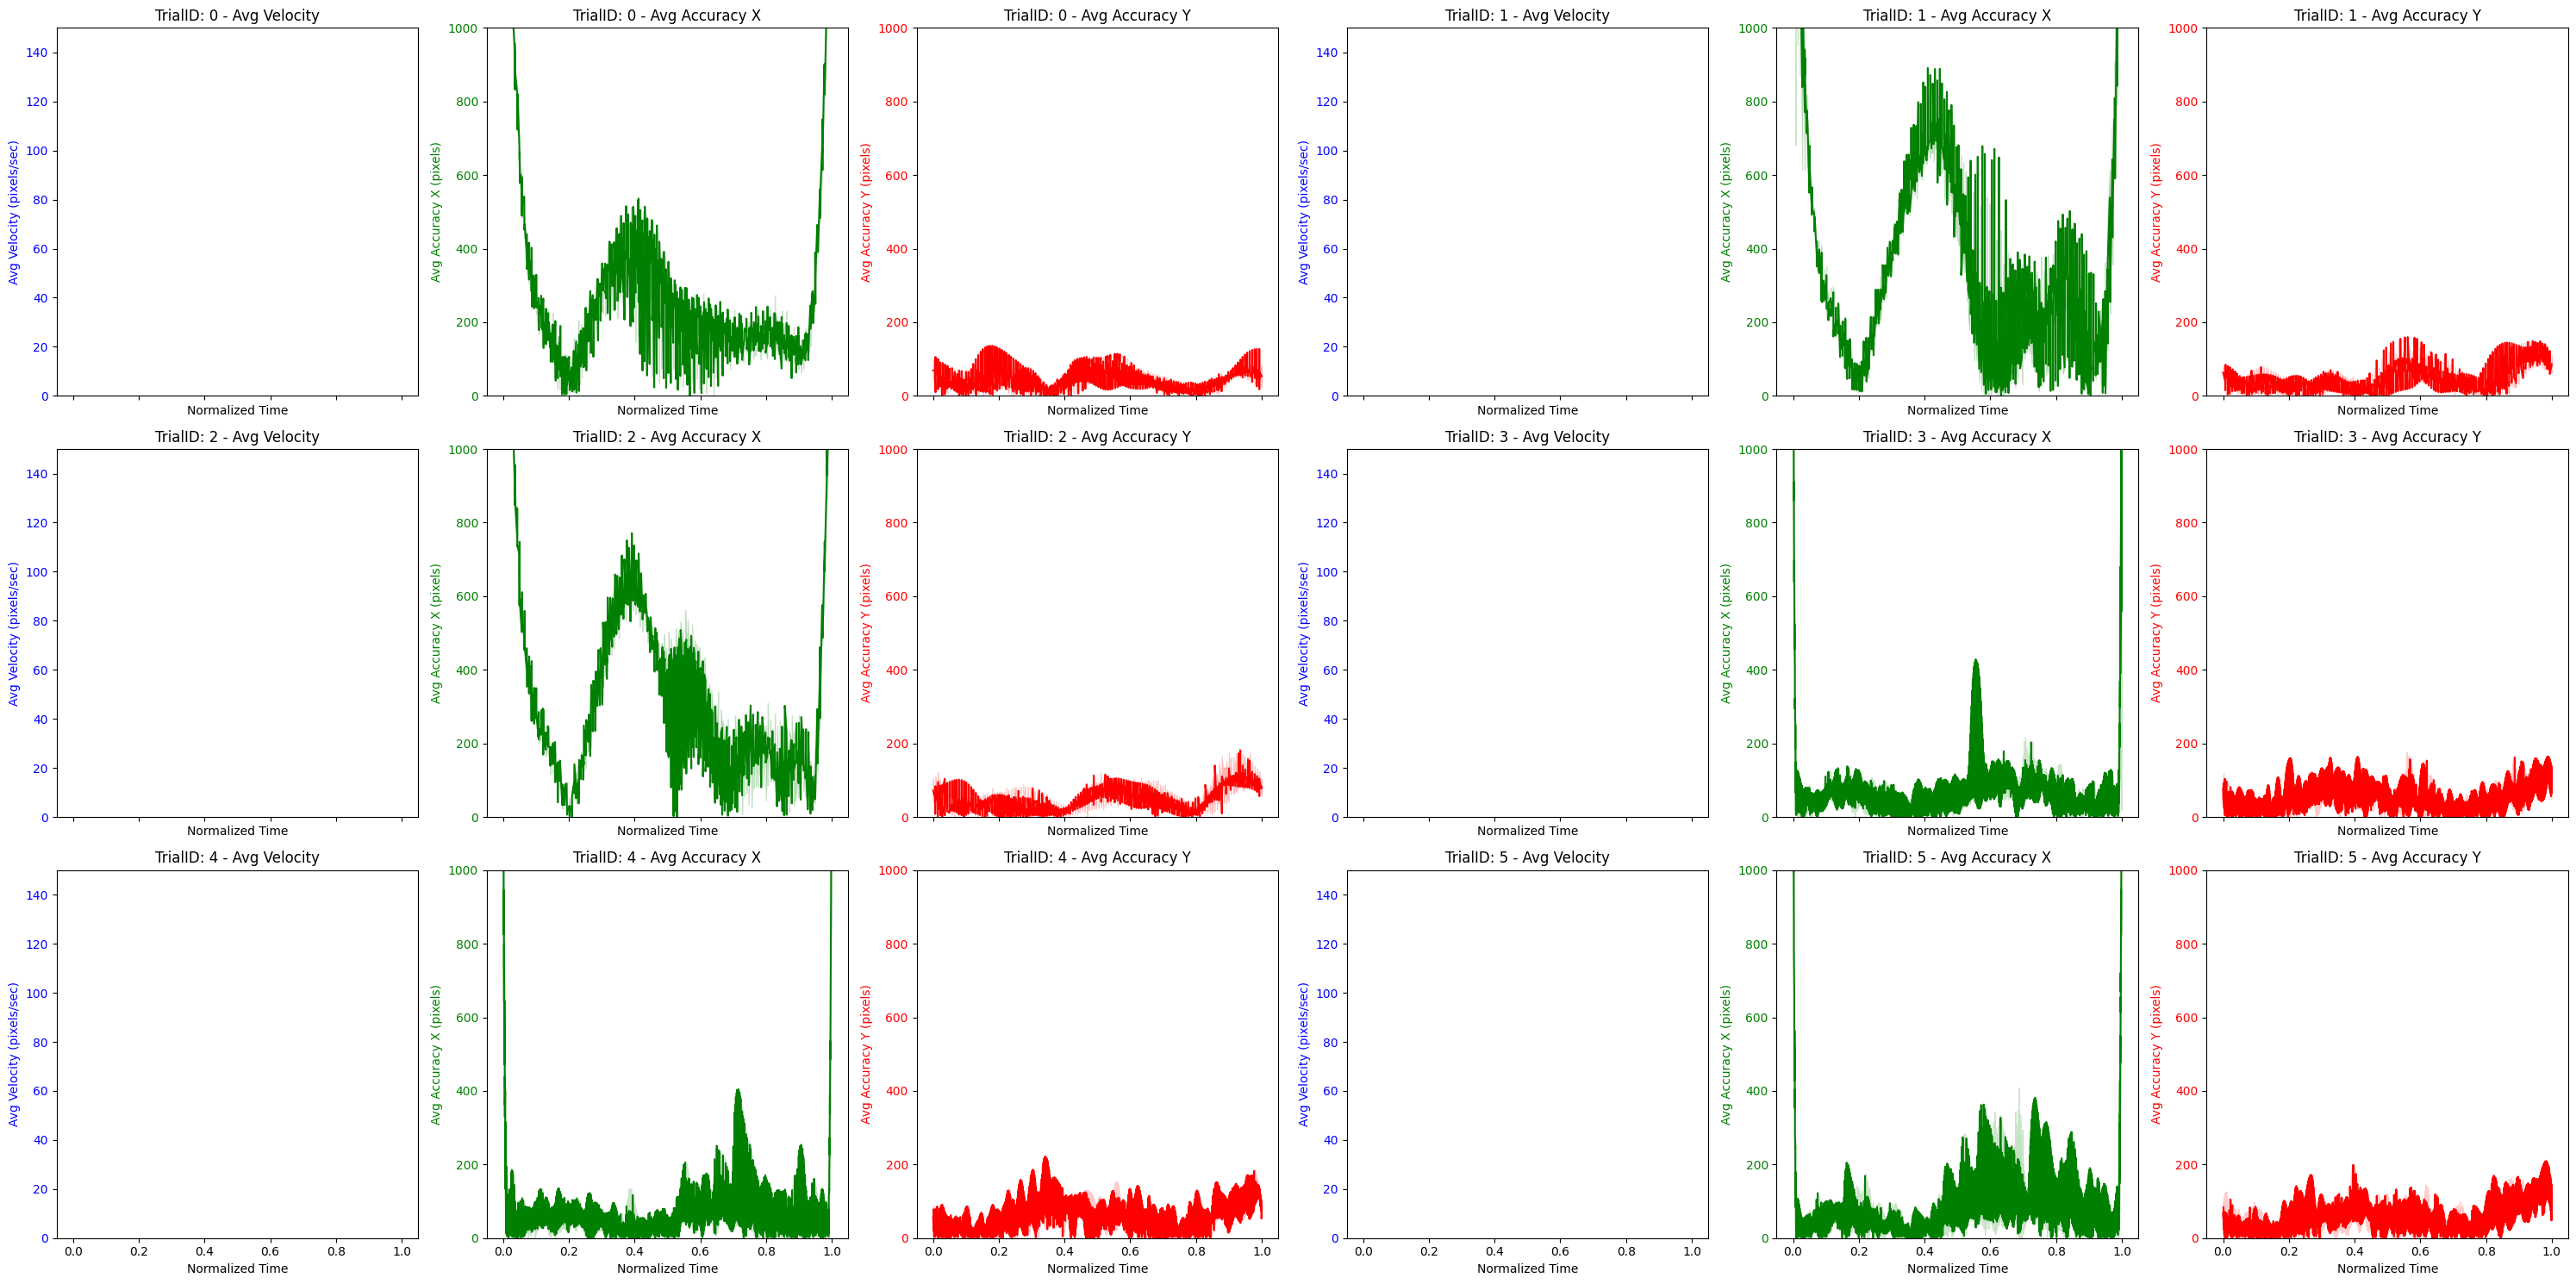

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Compute Eye Movement Velocity using Relative Time
def compute_velocity(df):
    # Calculate time difference instead of frame difference
    df['TimeDiff'] = df['RelativeTime'].diff().fillna(1e-5)  # Small value to avoid division by zero
    df['PosDiff'] = np.sqrt((df['BestPogX'].diff() ** 2) + (df['BestPogY'].diff() ** 2))
    df['Velocity'] = df['PosDiff'] / df['TimeDiff']  # Velocity as pixels per second
    return df

# Step 2: Compute Accuracy Relative to the Ball Position (separate X and Y)
def compute_accuracy(df, screen_width, screen_height):
    df['MappedPogX'] = df['BestPogX'] * screen_width
    df['MappedPogY'] = df['BestPogY'] * screen_height

    # Extract BallX and BallY from the ScreenBallPosition column
    df[['BallX', 'BallY']] = df['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
    df = df[(df['BallX'] >= 0) & (df['BallY'] >= 0)]
    df['AccuracyX'] = np.abs(df['MappedPogX'] - df['BallX'])
    df['AccuracyY'] = np.abs(df['MappedPogY'] - df['BallY'])
    return df

# Step 3: Align time values, normalize to [0, 1], and average across trials of the same type (trialID) with MSE
def align_and_average_across_trials(df, screen_width, screen_height, trial_ids=None):
    # Filter DataFrame to include only specified trial IDs
    if trial_ids is not None:
        df = df[df['TrialID'].isin(trial_ids)]
    
    # Align Time: Create RelativeTime for each trial, starting at 0
    df['RelativeTime'] = df.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())
    
    # Compute Velocity and Accuracy
    df = compute_velocity(df)
    df = compute_accuracy(df, screen_width, screen_height)
    
    # Normalize Relative Time to the range [0, 1]
    df['MaxRelativeTime'] = df.groupby('TrialNumber')['RelativeTime'].transform('max')
    df['NormalizedTime'] = df['RelativeTime'] / df['MaxRelativeTime']

    # Interpolate missing values for shorter trials with 100 points
    all_normalized_times = pd.DataFrame({'NormalizedTime': np.linspace(0, 1, num=100)})
    
    avg_df = []
    
    for trial_id in df['TrialID'].unique():
        trial_data = df[df['TrialID'] == trial_id]
    
        # Calculate mean and MSE across all trials of the same type (trialID)
        avg_by_trial_id = trial_data.groupby('NormalizedTime').agg(
            AvgVelocity=('Velocity', 'mean'),
            MSEVelocity=('Velocity', lambda x: np.mean((x - x.mean())**2)),
            AvgAccuracyX=('AccuracyX', 'mean'),
            MSEAccuracyX=('AccuracyX', lambda x: np.mean((x - x.mean())**2)),
            AvgAccuracyY=('AccuracyY', 'mean'),
            MSEAccuracyY=('AccuracyY', lambda x: np.mean((x - x.mean())**2))
        ).reset_index()
        
        avg_by_trial_id['TrialID'] = trial_id
        avg_df.append(avg_by_trial_id)

    # Concatenate all averaged trials
    avg_df = pd.concat(avg_df)
    return avg_df

# Step 4: Plot the aligned and averaged metrics by trialID with MSE regions
def plot_aligned_average_metrics_by_trialID(avg_df, screen_width, screen_height, trial_ids=None):
    # Filter avg_df to include only specified trial IDs
    if trial_ids is not None:
        avg_df = avg_df[avg_df['TrialID'].isin(trial_ids)]
    
    unique_trial_ids = sorted(avg_df['TrialID'].unique())  # Ensure TrialIDs are ordered
    num_trials = len(unique_trial_ids)
    num_rows = (num_trials + 1) // 2  # Each row contains 2 trials

    # Create subplots: 6 columns (2 trials per row, each with velocity and X/Y accuracy)
    fig, axes = plt.subplots(num_rows, 6, figsize=(30, 5 * num_rows), sharex=True)

    for i, trial_id in enumerate(unique_trial_ids):
        trial_avg = avg_df[avg_df['TrialID'] == trial_id]

        row = i // 2
        col_velocity = (i % 2) * 3  # First column for velocity
        col_accuracy_x = col_velocity + 1  # Second column for X accuracy
        col_accuracy_y = col_velocity + 2  # Third column for Y accuracy

        # Plot average Velocity and MSE region in the first column for each trialID
        ax_velocity = axes[row, col_velocity]
        ax_velocity.plot(trial_avg['NormalizedTime'], trial_avg['AvgVelocity'], color='blue', label='Avg Velocity')
        ax_velocity.fill_between(trial_avg['NormalizedTime'],
                                 trial_avg['AvgVelocity'] - np.sqrt(trial_avg['MSEVelocity']),
                                 trial_avg['AvgVelocity'] + np.sqrt(trial_avg['MSEVelocity']),
                                 color='blue', alpha=0.2, label='MSE Region')
        ax_velocity.set_ylabel('Avg Velocity (pixels/sec)', color='blue')
        ax_velocity.tick_params(axis='y', labelcolor='blue')
        ax_velocity.set_title(f'TrialID: {trial_id} - Avg Velocity')
        ax_velocity.set_ylim([0, 150])
        ax_velocity.set_xlabel('Normalized Time')

        # Plot average Accuracy (X) and MSE region in the second column for each trial
        ax_accuracy_x = axes[row, col_accuracy_x]
        ax_accuracy_x.plot(trial_avg['NormalizedTime'], trial_avg['AvgAccuracyX'], color='green', label='Avg Accuracy X')
        ax_accuracy_x.fill_between(trial_avg['NormalizedTime'],
                                   trial_avg['AvgAccuracyX'] - np.sqrt(trial_avg['MSEAccuracyX']),
                                   trial_avg['AvgAccuracyX'] + np.sqrt(trial_avg['MSEAccuracyX']),
                                   color='green', alpha=0.2, label='MSE Region')
        ax_accuracy_x.set_ylabel('Avg Accuracy X (pixels)', color='green')
        ax_accuracy_x.tick_params(axis='y', labelcolor='green')
        ax_accuracy_x.set_title(f'TrialID: {trial_id} - Avg Accuracy X')
        ax_accuracy_x.set_ylim([0, 1000])
        ax_accuracy_x.set_xlabel('Normalized Time')

        # Plot average Accuracy (Y) and MSE region in the third column for each trial
        ax_accuracy_y = axes[row, col_accuracy_y]
        ax_accuracy_y.plot(trial_avg['NormalizedTime'], trial_avg['AvgAccuracyY'], color='red', label='Avg Accuracy Y')
        ax_accuracy_y.fill_between(trial_avg['NormalizedTime'],
                                   trial_avg['AvgAccuracyY'] - np.sqrt(trial_avg['MSEAccuracyY']),
                                   trial_avg['AvgAccuracyY'] + np.sqrt(trial_avg['MSEAccuracyY']),
                                   color='red', alpha=0.2, label='MSE Region')
        ax_accuracy_y.set_ylabel('Avg Accuracy Y (pixels)', color='red')
        ax_accuracy_y.tick_params(axis='y', labelcolor='red')
        ax_accuracy_y.set_title(f'TrialID: {trial_id} - Avg Accuracy Y')
        ax_accuracy_y.set_ylim([0, 1000])
        ax_accuracy_y.set_xlabel('Normalized Time')

    fig.tight_layout()
    plt.show()

# Step 5: Align, average, and plot metrics with selected trialIDs, normalized time, and MSE regions
selected_trial_ids = [0, 1, 2, 3]  # Example list of trial IDs to plot
aligned_avg_data_by_trial = align_and_average_across_trials(data, screen_width, screen_height, trial_ids=selected_trial_ids)
plot_aligned_average_metrics_by_trialID(aligned_avg_data_by_trial, screen_width, screen_height, trial_ids=selected_trial_ids)


individual trials


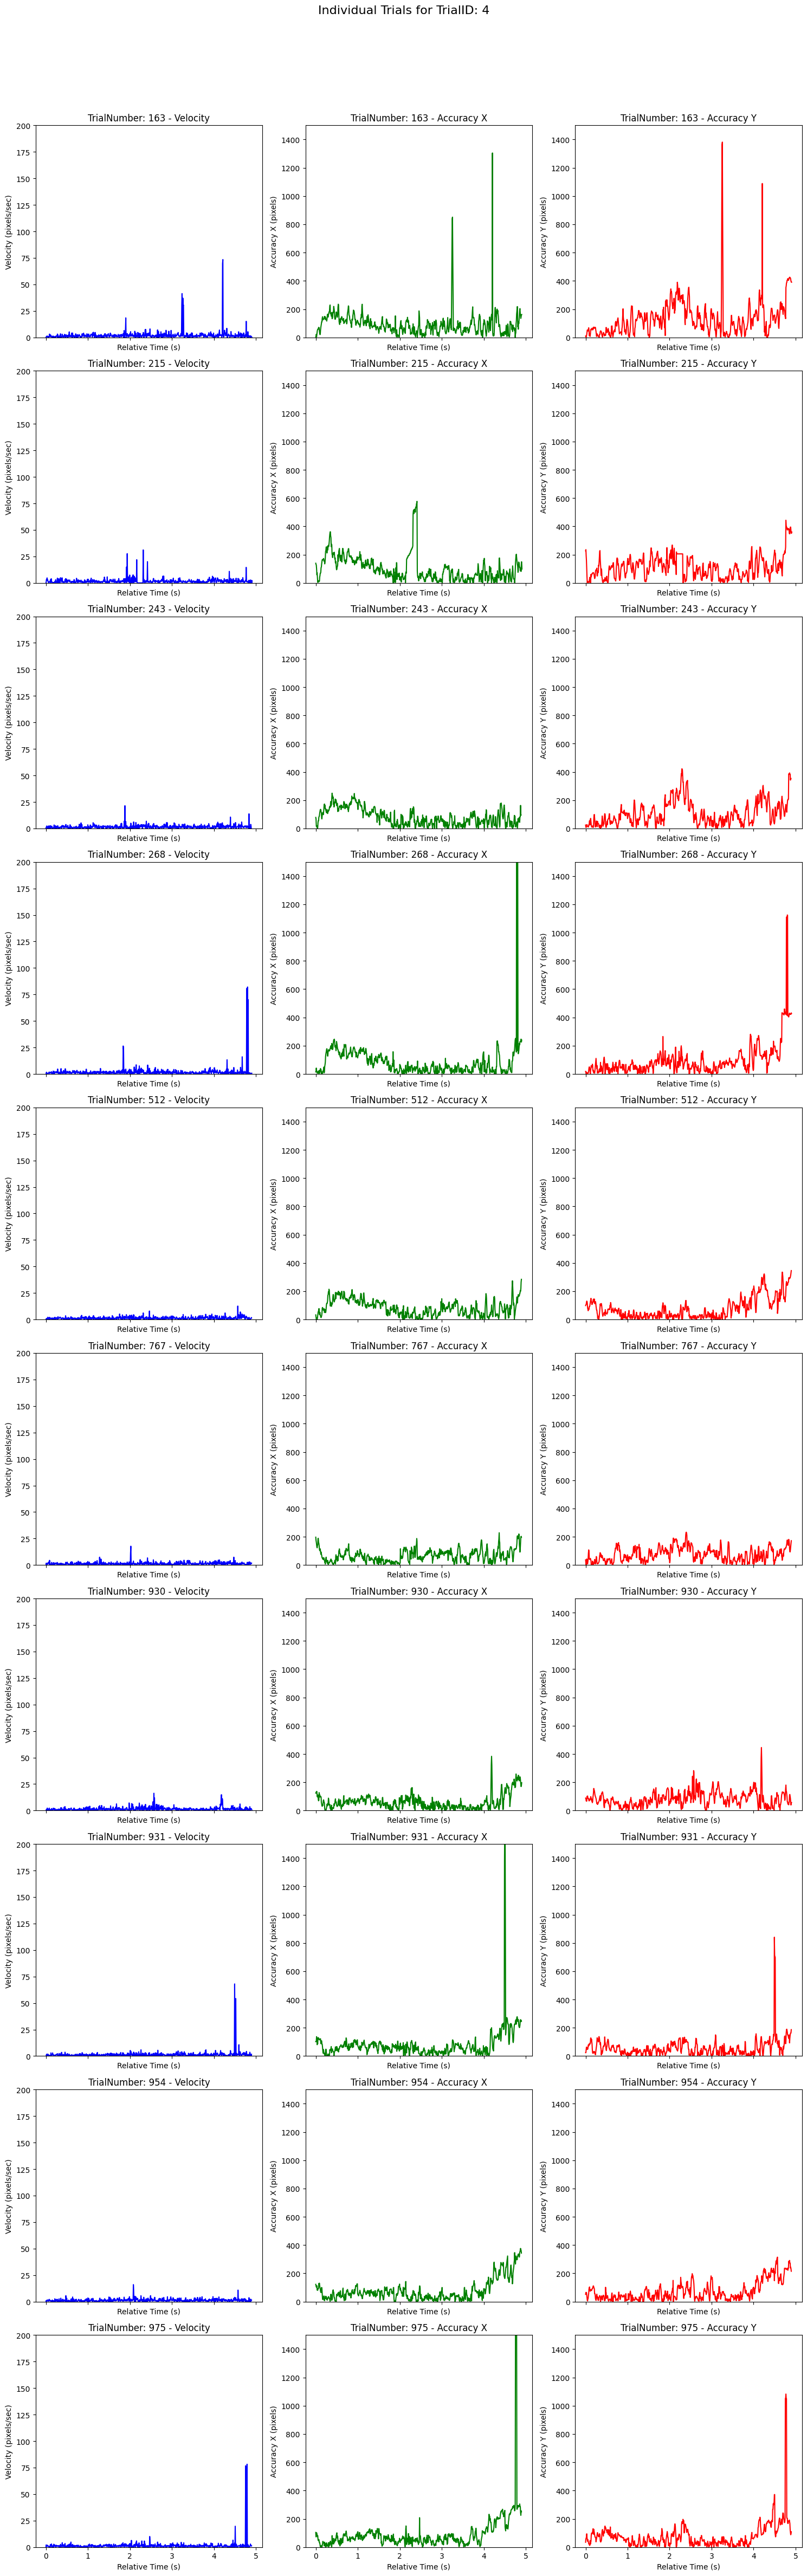

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def compute_velocity_and_accuracy(df, screen_width, screen_height):
    # Compute Time Difference
    df['TimeDiff'] = df['RelativeTime'].diff().fillna(1e-5)  # Small value to avoid division by zero

    # Compute Position Difference for Velocity
    df['PosDiff'] = np.sqrt((df['BestPogX'].diff() ** 2) + (df['BestPogY'].diff() ** 2))
    df['Velocity'] = df['PosDiff'] / df['TimeDiff']  # Velocity as pixels per second

    # Compute Accuracy Relative to Ball Position
    df['MappedPogX'] = df['BestPogX'] * screen_width
    df['MappedPogY'] = df['BestPogY'] * screen_height

    # Extract BallX and BallY from the ScreenBallPosition column, handling negative values
    df[['BallX', 'BallY']] = df['ScreenBallPosition'].str.extract(r'\((\d+\.?\d*)\s(\d+\.?\d*)\)').astype(float)
    # Filter out rows where BallX or BallY is negative
    df = df[(df['BallX'] >= 0) & (df['BallY'] >= 0)]

    # Calculate Accuracy in X and Y directions
    df['AccuracyX'] = np.abs(df['MappedPogX'] - df['BallX'])
    df['AccuracyY'] = np.abs(df['MappedPogY'] - df['BallY'])

    return df

# Function to plot individual trials within a given range for a specific TrialID using RelativeTime
def plot_individual_trials(df, trial_id, trial_range=(0, 4)):
    # Filter the data for the specified TrialID
    trial_data = df[df['TrialID'] == trial_id]

    # Get the unique trial numbers within the specified range
    trial_numbers = trial_data['TrialNumber'].unique()
    start, end = trial_range
    selected_trials = trial_numbers[start:end+1]  # Select trials within the range

    # Create a figure for each trial in the range
    fig, axes = plt.subplots(len(selected_trials), 3, figsize=(15, 5 * len(selected_trials)), sharex=True)
    fig.suptitle(f'Individual Trials for TrialID: {trial_id}', fontsize=16)
    
    for i, trial_num in enumerate(selected_trials):
        single_trial_data = trial_data[trial_data['TrialNumber'] == trial_num]

        # Ensure we can handle subplots when there's only one row
        if len(selected_trials) == 1:
            axes_row = axes
        else:
            axes_row = axes[i]

        # Plot Velocity
        axes_row[0].plot(single_trial_data['RelativeTime'], single_trial_data['Velocity'], color='blue')
        axes_row[0].set_title(f'TrialNumber: {trial_num} - Velocity')
        axes_row[0].set_ylabel('Velocity (pixels/sec)')
        axes_row[0].set_xlabel('Relative Time (s)')
        axes_row[0].set_ylim([0, 200])

        # Plot Accuracy X
        axes_row[1].plot(single_trial_data['RelativeTime'], single_trial_data['AccuracyX'], color='green')
        axes_row[1].set_title(f'TrialNumber: {trial_num} - Accuracy X')
        axes_row[1].set_ylabel('Accuracy X (pixels)')
        axes_row[1].set_xlabel('Relative Time (s)')
        axes_row[1].set_ylim([0, 1500])

        # Plot Accuracy Y
        axes_row[2].plot(single_trial_data['RelativeTime'], single_trial_data['AccuracyY'], color='red')
        axes_row[2].set_title(f'TrialNumber: {trial_num} - Accuracy Y')
        axes_row[2].set_ylabel('Accuracy Y (pixels)')
        axes_row[2].set_xlabel('Relative Time (s)')
        axes_row[2].set_ylim([0, 1500])

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

# Example usage
# Create RelativeTime for each trial, starting at 0
data['RelativeTime'] = data.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())

# Compute velocity and accuracy
data = compute_velocity_and_accuracy(data, screen_width, screen_height)

# Plot individual trials
plot_individual_trials(data, trial_id=4, trial_range=(0, 9))


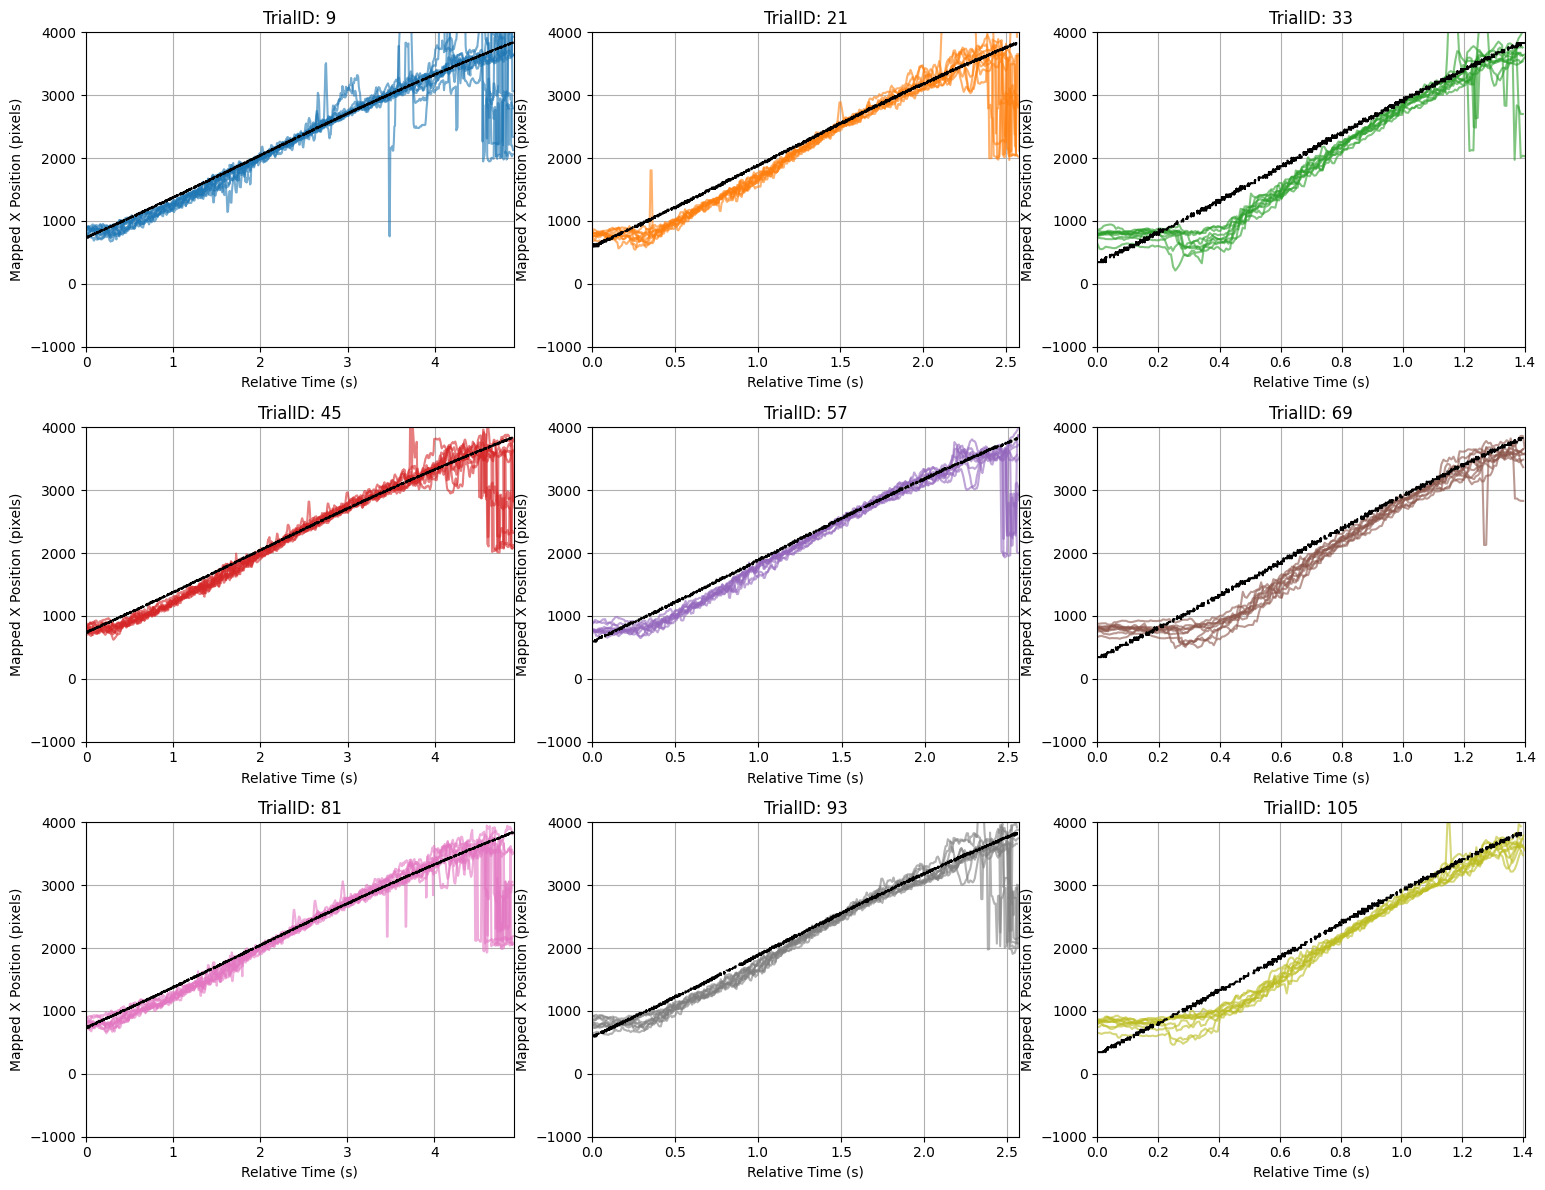

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_individual_trials_with_object_position_auto_zoom(df, trial_ids=None, alpha=0.6):
    # Filter DataFrame to include only specified trial IDs if provided
    if trial_ids is not None:
        df = df[df['TrialID'].isin(trial_ids)]

    # Ensure data is sorted by TrialID and RelativeTime
    df = df.sort_values(by=['TrialID', 'RelativeTime'])

    # Get unique TrialIDs to plot
    trial_ids = df['TrialID'].unique()
    num_trials = len(trial_ids)
    
    # Set up the grid for subplots with 3 columns
    num_cols = 3
    num_rows = (num_trials + num_cols - 1) // num_cols  # Calculate rows based on the number of trials
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows), sharex=False, sharey=False)
    axes = axes.flatten()  # Flatten to make indexing easier
    
    # Plot each TrialID in a separate subplot
    for i, trial_id in enumerate(trial_ids):
        # Get the correct axis for the current TrialID
        ax = axes[i]

        # Filter the data for the current TrialID
        trial_data = df[df['TrialID'] == trial_id]
        
        # Plot each individual trial for the current TrialID
        for trial_num in trial_data['TrialNumber'].unique():
            single_trial_data = trial_data[trial_data['TrialNumber'] == trial_num]
            ax.plot(single_trial_data['RelativeTime'], single_trial_data['MappedPogX'],
                    color=f"C{i}", label=f'Trial {trial_num}' if trial_num == trial_data['TrialNumber'].unique()[0] else "", alpha=alpha)
        
        # Plot the absolute object position X as a black line
        ax.plot(trial_data['RelativeTime'], trial_data['BallX'], color='black', linestyle='--', label='Object X Position')
        
        # Set individual plot limits based on min and max values for each TrialID
        x_min, x_max = trial_data['RelativeTime'].min(), trial_data['RelativeTime'].max()
        y_min, y_max = trial_data['MappedPogX'].min(), trial_data['MappedPogX'].max()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(-1000, 4000)

        # Customize each subplot
        ax.set_title(f'TrialID: {trial_id}')
        ax.set_xlabel("Relative Time (s)")
        ax.set_ylabel("Mapped X Position (pixels)")
        ax.grid(True)

    # Remove empty subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.subplots_adjust(right=0.85)  # Adjust layout to fit the legend outside
    plt.show()

# Example usage
# Specify the trial IDs to plot
selected_trial_ids = [9, 21, 33, 45, 57, 69, 81, 93, 105]  # Example list of trial IDs to plot

# Create RelativeTime for each trial, starting at 0
data['RelativeTime'] = data.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())

# Compute velocity and accuracy
data = compute_velocity_and_accuracy(data, screen_width, screen_height)

# Plot individual trials
plot_individual_trials_with_object_position_auto_zoom(data, trial_ids=selected_trial_ids, alpha=0.6)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_combined_trials_with_object_position_auto_zoom(df, trial_id_groups=None, alpha=0.6):
    # Flatten and filter DataFrame based on all trial IDs in the list of lists
    if trial_id_groups is not None:
        all_trial_ids = [trial_id for sublist in trial_id_groups for trial_id in sublist]
        df = df[df['TrialID'].isin(all_trial_ids)]

    # Ensure data is sorted by TrialID and RelativeTime
    df = df.sort_values(by=['TrialID', 'RelativeTime'])

    # Set up the grid for subplots with 3 columns
    num_cols = 3
    num_rows = (len(trial_id_groups) + num_cols - 1) // num_cols  # Calculate rows based on number of groups
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows), sharex=False, sharey=False)
    axes = axes.flatten()  # Flatten to make indexing easier

    # Plot each group of TrialIDs in a separate subplot
    for i, trial_id_group in enumerate(trial_id_groups):
        # Get the correct axis for the current group
        ax = axes[i]

        # Plot each individual trial in the current group
        for trial_id in trial_id_group:
            # Filter the data for the current TrialID
            trial_data = df[df['TrialID'] == trial_id]

            # Plot each individual trial for the current TrialID in the group
            for trial_num in trial_data['TrialNumber'].unique():
                single_trial_data = trial_data[trial_data['TrialNumber'] == trial_num]
                ax.plot(single_trial_data['RelativeTime'], single_trial_data['MappedPogX'],
                        label=f'Trial {trial_num}', alpha=alpha)

            # Plot the absolute object position X as a black line
            ax.plot(trial_data['RelativeTime'], trial_data['BallX'], color='black', linestyle='--', label='Object X Position')
        
        # Set individual plot limits based on min and max values for the group
        group_data = df[df['TrialID'].isin(trial_id_group)]
        x_min, x_max = group_data['RelativeTime'].min(), group_data['RelativeTime'].max()
        y_min, y_max = group_data['MappedPogX'].min(), group_data['MappedPogX'].max()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(-1000, 4000)

        # Customize each subplot
        ax.set_title(f'Trial Group: {trial_id_group}')
        ax.set_xlabel("Relative Time (s)")
        ax.set_ylabel("Mapped X Position (pixels)")
        ax.grid(True)

    # Remove empty subplots if any
    for j in range(len(trial_id_groups), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.subplots_adjust(right=0.85)  # Adjust layout to fit the legend outside
    plt.show()

# Example usage
# Specify the groups of trial IDs to plot
trial_id_groups = [
    [9, 21, 33], 
    [45, 57, 69], 
    [81, 93, 105]
]  # Each inner list represents a group of TrialIDs to be plotted together

# Create RelativeTime for each trial, starting at 0
data['RelativeTime'] = data.groupby('TrialNumber')['Time'].transform(lambda x: x - x.min())

# Compute velocity and accuracy
data = compute_velocity_and_accuracy(data, screen_width, screen_height)

# Plot combined trials
plot_combined_trials_with_object_position_auto_zoom(data, trial_id_groups=trial_id_groups, alpha=0.6)
